In [9]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import sklearn.discriminant_analysis as DA
from sklearn.linear_model import SGDClassifier
import sklearn.cross_validation as cv
from sklearn.metrics import roc_curve, auc


def AMS(s, b):
    '''
    Approximate median significance:
        s = true positive rate
        b = false positive rate
    '''
    assert s >= 0
    assert b >= 0
    bReg = 10.
    return np.sqrt(2.0 * ((s + b + bReg) * np.log(1 + s / (b + bReg)) - s))


def get_rates(prediction, solution, weights):
    '''
    Returns the true and false positive rates.
    This assumes that:
        label 's' corresponds to 1 (int)
        label 'b' corresponds to 0 (int)
    '''
    assert prediction.size == solution.size
    assert prediction.size == weights.size

    # Compute sum of weights for true and false positives
    truePos  = sum(weights[(solution == 1) * (prediction == 1)])
    falsePos = sum(weights[(solution == 0) * (prediction == 1)])

    return truePos, falsePos


fname='X_y'
df=pd.read_csv(fname)

df.replace(-999.0,0.)
cols = df.columns.tolist()
X=df[cols[:-2]].values
labels = df['Label'].values
weights = df['Weight'].values

In [7]:
def train_lda_classfier(X,y,weight,nfolds):
    kf = cv.KFold(labels.size, n_folds=nfolds)
    
    npoints  = 26
    all_AMS = {}
    for curr in range(npoints):
        all_AMS[curr] = []
    cutoffs  = np.linspace(0.05, 0.30, npoints)
    
    for train_indices, test_indices in kf:
        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]
        w_train, w_test = weight[train_indices], weight[test_indices]
        
        w_train *= (sum(weight) / sum(w_train))
        w_test  *= (sum(weight) / sum(w_test))
        
        Clf=DA.LinearDiscriminantAnalysis()
        
        Clf.fit(X_train,y_train)
        
        y_out = Clf.predict(X_test)
        res  = [(i, y_out[i]) for i in xrange(len(y_out))]
        
        rorder = {}
        for k, v in sorted(res, key = lambda x:-x[1]):
            rorder[k] = len(rorder) + 1
        
        best_AMS = -1.
        best_thres = 0.0
        
        for curr, threshold_ratio in enumerate(cutoffs):
            y_pred = np.zeros(len(y_out))
            ntop = int(threshold_ratio * len(rorder))
            for k, v in res:
                if rorder[k] <= ntop:
                    y_pred[k] = 1

            truePos, falsePos = get_rates(y_pred, y_test, w_test)
            this_AMS = AMS(truePos, falsePos)
            all_AMS[curr].append(this_AMS)
            if this_AMS > best_AMS:
                best_AMS = this_AMS
                best_thres = threshold_ratio
        print "Best AMS = %f at %.2f"%(best_AMS,best_thres)
    print "------------------------------------------------------"
    
        
        
    fpr1, tpr1, _ = roc_curve(y_test, Clf.decision_function(X_test))
    roc_auc1 = auc(fpr1, tpr1)
        
    plt.plot(fpr1,tpr1,color='r',label='ROC curve (area = %0.2f)' % roc_auc1)
    plt.legend(loc="lower right")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.show()
    
    from sklearn.externals import joblib    
    joblib.dump(Clf, 'lda.pkl')

Best AMS = 1.432344 at 0.23
Best AMS = 1.406258 at 0.23
Best AMS = 1.347808 at 0.23
Best AMS = 1.426686 at 0.23
Best AMS = 1.475496 at 0.24
Best AMS = 1.412428 at 0.23
Best AMS = 1.396298 at 0.23
Best AMS = 1.436668 at 0.24
Best AMS = 1.422753 at 0.23
Best AMS = 1.453276 at 0.24
------------------------------------------------------


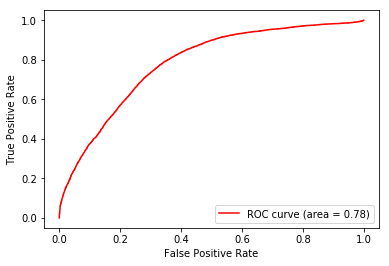

In [8]:
train_lda_classfier(X,labels,weights,10)

In [10]:
def train_sgdc_classfier(X,y,weight,nfolds):
    kf = cv.KFold(labels.size, n_folds=nfolds)
    
    npoints  = 26
    all_AMS = {}
    for curr in range(npoints):
        all_AMS[curr] = []
    cutoffs  = np.linspace(0.05, 0.30, npoints)
    
    for train_indices, test_indices in kf:
        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]
        w_train, w_test = weight[train_indices], weight[test_indices]
        
        w_train *= (sum(weight) / sum(w_train))
        w_test  *= (sum(weight) / sum(w_test))
        
        Clf=SGDClassifier()
        
        Clf.fit(X_train,y_train)
        
        y_out = Clf.predict(X_test)
        res  = [(i, y_out[i]) for i in xrange(len(y_out))]
        
        rorder = {}
        for k, v in sorted(res, key = lambda x:-x[1]):
            rorder[k] = len(rorder) + 1
        
        best_AMS = -1.
        best_thres = 0.0
        
        for curr, threshold_ratio in enumerate(cutoffs):
            y_pred = np.zeros(len(y_out))
            ntop = int(threshold_ratio * len(rorder))
            for k, v in res:
                if rorder[k] <= ntop:
                    y_pred[k] = 1

            truePos, falsePos = get_rates(y_pred, y_test, w_test)
            this_AMS = AMS(truePos, falsePos)
            all_AMS[curr].append(this_AMS)
            if this_AMS > best_AMS:
                best_AMS = this_AMS
                best_thres = threshold_ratio
        print "Best AMS = %f at %.2f"%(best_AMS,best_thres)
    print "------------------------------------------------------"
    
        
        
    fpr1, tpr1, _ = roc_curve(y_test, Clf.decision_function(X_test))
    roc_auc1 = auc(fpr1, tpr1)
        
    plt.plot(fpr1,tpr1,color='r',label='ROC curve (area = %0.2f)' % roc_auc1)
    plt.legend(loc="lower right")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.show()
    
    from sklearn.externals import joblib    
    joblib.dump(Clf, 'sgdc.pkl')

Best AMS = 0.772884 at 0.15
Best AMS = 0.657988 at 0.14
Best AMS = 0.820122 at 0.18
Best AMS = 0.816708 at 0.30
Best AMS = 0.603516 at 0.30
Best AMS = 0.857699 at 0.15
Best AMS = 0.920351 at 0.30
Best AMS = 0.631650 at 0.08
Best AMS = 0.638489 at 0.07
Best AMS = 0.751179 at 0.30
------------------------------------------------------


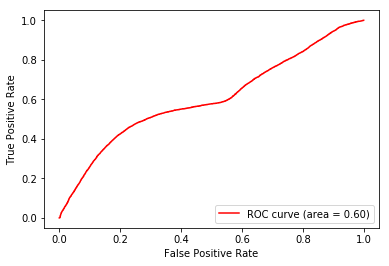

In [11]:
train_sgdc_classfier(X,labels,weights,10)